                                                                                                Patricia Grau Francitorra

# Assignment 1: Chinese character "detection"

**Introduction**

Optical character recognition is an old "AI" and image-processing task.  What it involves is taking a photograph or scan of a piece of text (printed or handwritten) and turning the characters (as images) into character codes on the computer that therefore allow the text to be edited, indexed, etc.  A key part of that process is identifying where the characters actually are, especially if the characters are mixed among other non-writing, such as images of objects or people.

In this assignment, you will **take images from a Chinese image database with annotations that indicate where the Chinese characters are, and you will train a model that takes test images, and superimposes upon them a visualization (of your choosing, e.g., a "heat map") of the likelihood that a pixel is close to or part of a valid Chinese character**.  The image database contains annotations of "bounding boxes", coordinates of the corners of a box that contains a single Chinese character.  In a sense, this assignment asks you to detect the bounding boxes in test images without the annotation, but a softer version of this: simply to **provide the probability, for each pixel, whether that pixel was part of a bounding box containing a Chinese character**.  Then, you are to 
   1. **superimpose upon the image a pixel-based map of likelihoods of where the bounding boxes ought to be** and
   2. **apply an evaluation statistic**.

This assignment grants you a lot of freedom in how you organize your code and set up the task overall.  Because of the degree of freedom it involves, it will mostly be graded on our evaluation of the effort put into the solution.  An actual high success at the task is not a requirement to get a high grade.  However, you will have to **report in detail**, in your own format, what you did, why you did it, how to run it -- it must run on mltgpu, be implemented in Python using PyTorch, and make use of the GPUs -- and how to apply it easily to our own test images.

You will have almost a month to do this assignment, even though it is worth only 30% of your grade.  Another assignment with 30% will be given out for the last/remaining two weeks of the study period.   These time periods are coextensive with that of the project, but we expect you to be able to schedule your time well enough to put in an effort at both. This assignment is officially due at 23:59 on 2021 October 18. There are 30 points on this assignment, and a maximum of 20 bonus points.

**The data**

The source of the task is here: https://ctwdataset.github.io/ (Links to an external site.) They have example images and an example of a baseline task that is much more advanced than what we are doing, but it will give you an idea of the data format, particularly the metadata.  Pay attention especially to the "Annotation format" section of this page: https://ctwdataset.github.io/tutorial/1-basics.html (Links to an external site.)

The metadata and a small sample of the whole image dataset is available at /scratch/lt2326-h21/a1 on mltgpu. The metadata is in json format.  info.json contains information about every image file.  We will unzip only a minority of the original training image files.  train.jsonl is a list of json entities, one per line (that have to be parsed with the json package each separately) that correspond to the files in info.json.  This contains the bounding box information, as well as other information for the original challenge on the web.  See the "Annotation format" section mentioned on the dataset web page linked above.

## Part 1: data preparation (7 points)

The image files are in /scratch/lt2326-h21/a1/images on mltgpu. They are in jpg format.  The code that you write for this part of the project should:

- Use the info.json file to figure out what files are in the training set.  You will just use the official training data for everything.  Remember that you will only see a small minority of training examples in the images directory, for space reasons.
- Divide up the official training data files into your own training, validation, and test datasets depending on your own preferences. You can choose to use fewer files than the maximum available if you run into problems with memory and so on (but first make sure your implementation is reasonably efficient).
- Find the corresponding bounding box information in train.jsonl for each image. 

You can represent the data in any way you like, but remember that **it will become a numpy array for processing and a torch tensor for training**.  Remember also that **the classes are defined by pixel: for each pixel, you will eventually have a set of features (e.g. colour values), and a binary class corresponding to whether the pixel was in a Chinese character bounding box or not (note that there are non-Chinese characters in the set -- see the annotation instructions)**.  You are allowed to **reduce the dimensionality of the images for processing, but consider using a pooling and/or upsampling technique in Part 2** of this assignment to accomplish this goal. 

Describe the choices you made and the challenges you found in your report.

In [1]:
import os, sys
from os import listdir
from PIL import Image
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mplpath

from skimage import transform

import random

from torch.utils.data import DataLoader

import time
from joblib import Parallel, delayed

In [2]:
# some info

# Opening JSON file
f = open('/scratch/lt2326-h21/a1/info.json',)

# returns JSON object as a dictionary
info = json.load(f)

# print(info.keys())
# print(info['train'][0])
# print(len(info['train']))

# gets the names of the images in train
im_in_train = []
for a in info['train']:
    name = a['image_id'] + '.jpg'
    im_in_train.append(name)

# Closing file
f.close()

In [3]:
with open('/scratch/lt2326-h21/a1/train.jsonl') as trainfile:
    traindata = [json.loads(x) for x in trainfile]

In [4]:
# checking what images are in the images folder

path = '/scratch/lt2326-h21/a1/images'
dirs = os.listdir(path)

usable_img_names = []
for img_name in dirs:
    if img_name in im_in_train:
        usable_img_names.append(img_name)
print('There are', len(usable_img_names), 'images in the image folder that come from the train file.')

# only taking the images that are in the folder

usable_data = []
for e in traindata:
    if e['file_name'] in usable_img_names:
        usable_data.append(e)

There are 845 images in the image folder that come from the train file.


In [5]:
# separating data into training, testing and validation data
# the train set consists of 80% of the data, test and validation sets are 10% of the data

random.shuffle(usable_data)

usable_train, usable_test, usable_val = np.split(usable_data, [int(len(usable_data)*0.8), int(len(usable_data)*0.9)])

print(len(usable_train), len(usable_test), len(usable_val)) # sanity test

676 84 85


In [6]:
# we have usable_train, a list that contains dictionaries for each image
# {image_id1 : {'chinese' : [[poligon 1], [poligon2]], 'non_chinese' : [[poligon 1], [poligon2]]}, image_id2 : {'chinese' : [pol1], [pol2], [pol3]], 'non_chinese': []...}...}
# We will have all the polygons of every image, the ones that contain chinese characters and the ones that don't

def get_chinese(some_usable):
    chinese_im = {}
    
    for image in some_usable:
        chinese_im[image['image_id']] = {'chinese' : [], 'non_chinese' : []}
        for anno in image['annotations']:
            for a in anno:
                if a['is_chinese']:
                    chinese_im[image['image_id']]['chinese'].append(a['polygon'])
                else:
                    chinese_im[image['image_id']]['non_chinese'].append(a['polygon'])
    return chinese_im

In [7]:
chi_train = get_chinese(usable_train)
chi_test = get_chinese(usable_test)
chi_val = get_chinese(usable_val)

train_im_names = list(chi_train.keys())
test_im_names = list(chi_test.keys())
val_im_names = list(chi_val.keys())

In [8]:
# just for one image
def imageAndTensor(image):  
    path = '/scratch/lt2326-h21/a1/images'
    
    # loading the image
    fullimg = mpimg.imread(path + "/" + image + ".jpg")
    img = transform.resize(fullimg, (200,200))

    # making it a tensor
    timg = torch.tensor(img)
    timg = timg.float()

    # preparing it for a conv layer
    permute = timg.permute((2, 0, 1))

    return permute

In [9]:
# just one image
def ImageGoldValues(chi_data, image):
   
    # making an empty grid
    grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
    grid.shape = (2048*2048, 2)

    # getting the path for each polygon and updating a 0 matrix
    zeros = np.zeros(2048*2048)

    for pol in chi_data[image]['chinese']:
        pol_path = mplpath.Path(pol)
        truthvals = pol_path.contains_points(grid)

        # turning it into 0s and 1s    
        truthvals = np.asarray(truthvals, int)

        # updating
        # we take the maximum in case there is the same pixel in different polygons
        zeros = np.maximum(truthvals, zeros)

    return torch.LongTensor(zeros)

In [10]:
def process_images_in_parallel(chi_data, image):
    return (imageAndTensor(image), 
            ImageGoldValues(chi_data, image))

In [11]:
start = time.time()
processed_train = Parallel(n_jobs = 10)(delayed(process_images_in_parallel)(chi_train, image) for image in chi_train)
end = time.time()

print("Processing data took", round(end-start, 0), "seconds")

Processing data took 1380.0 seconds


In [12]:
# loading the validation set
start = time.time()
processed_val = Parallel(n_jobs = 10)(delayed(process_images_in_parallel)(chi_val, image) for image in chi_val)
end = time.time()

print("Processing data took", round(end-start, 0), "seconds")

Processing data took 150.0 seconds


In [13]:
# loading the test set
start = time.time()
processed_test = Parallel(n_jobs = 10)(delayed(process_images_in_parallel)(chi_test, image) for image in chi_test)
end = time.time()

print("Processing data took", round(end-start, 0), "seconds")

Processing data took 151.0 seconds


## Part 2: the models (10 points)

In this part, you will implement two substantially different model archictectures, that both take your representation of the images as training input and both take your representation of the bounding boxes as objective (HINT: the binary classification of pixels as belonging to a bounding box or not).  They will save the trained models to files so that they can be loaded and tested later. The output of the models will be a "soft binary" -- the probability of each pixel being inside a bounding box, from 0 to 1.  Consider examining some of the training data before designing your architectures.

You have a large grant of freedom as to what these model architectures will look like (remember: grading is on a "reasonable effort" basis).  There's a high chance (HINT) that they will both use **one or more convolutional layers**, among other things.  Describe the models and the motivations for the architecture in your report.

- First model

In [29]:
# hyperparameters 1
# device = torch.device('cpu')
device = torch.device('cuda:1')

batch_size = 4  
learning_rate = 1e-5
epochs = 5

In [19]:
train_dataloader = DataLoader(processed_train, batch_size=batch_size, shuffle=True)

In [30]:
# The first model will be based in LeNet (1998)
# two conv layers and three fully connected layers
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.linear1 = nn.Linear(3*50*50, 1*50*50)
        self.relu3 = nn.ReLU()
        
        self.linear2 =  nn.Linear(50*50, 500)
        self.relu4 = nn.ReLU()
        
        self.linear3 = nn.Linear(500, 100)
        self.relu5 = nn.ReLU()

    
    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        
        y = y.view(y.shape[0], -1)
        
        y = self.linear1(y)
        y = self.relu3(y)
        
        y = self.linear2(y)
        y = self.relu4(y)
        
        y = self.linear3(y)
        y = self.relu5(y)
        
        return y

In [31]:
firstmodel = FirstModel().to(device)

In [32]:
def train(model, train_dataloader, device):
    loss = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    upsampling = nn.Upsample((2048,2048))
    
    loss_plot = []
    
    model.train()

    for e in range(epochs):
        epoch_loss = 0
        
        for i, (tensors, matrix) in enumerate(train_dataloader):
            tensors = tensors.to(device)
            matrix = matrix.to(torch.float32).to(device)

            y = model(tensors).to(device)
            
            reshaping = y.reshape((y.size()[0], 10, 10, 1))
            reshaping = reshaping.permute((0, 3, 1, 2))

            bigboi = upsampling(reshaping)
            output = bigboi.permute((0, 2, 3, 1))
            output = output.reshape(y.size()[0], 2048*2048)
            
            batch_loss = loss(output, matrix)
            epoch_loss += batch_loss.item()
            
            print(epoch_loss/(i+1), end='\r')
            
            
            loss_plot.append(epoch_loss)
            batch_loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()
        
        print()
    plt.plot(loss_plot)
        
    return model

In [19]:
# device = torch.device("cpu")
device = torch.device('cuda:1')

In [20]:
# torch.save(m1, 'firstmodel.pt')

In [21]:
# firstmodel = torch.load("firstmodel.pt").to(device)

0.34143170361688155
0.25476299074186376
0.26066005811888794
0.27822685307828634
0.27672176393707826


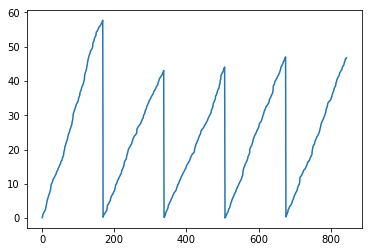

In [33]:
# FirstModel with a learning rate of 1e-5
m1 = train(firstmodel, train_dataloader, device)

In [34]:
# hyperparameters 2
# device = torch.device('cpu')
device = torch.device('cuda:1')

batch_size = 4  
learning_rate = 0.0001
epochs = 5

0.41526503195247705
0.44878452670203866
0.35242990018612536
0.32647237730537653
0.30026793777501793


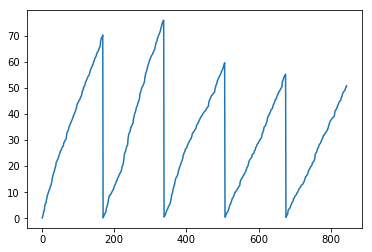

In [35]:
# FirstModel with a learning rate of 0.0001
m1_1 = train(firstmodel, train_dataloader, device)

In [36]:
# torch.save(m1_1, 'firstmodel_differentlr.pt')

In [37]:
# firstmodel_1 = torch.load("firstmodel_differentlr.pt").to(device)

- First model, second version

In [38]:
# Let's keep the first learning rate but change the size of the kernel in the first convolutional layer

In [39]:
# The first model will be based in LeNet (1998)
# two conv layers and three fully connected layers
# the first conv layer has a kernel size of 5 that is reduced to 3 in the second conv layer
class FirstModel2(nn.Module):
    def __init__(self):
        super(FirstModel2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 3, (5, 5), 1, padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.linear1 = nn.Linear(3*49*49, 1*50*50)
        self.relu3 = nn.ReLU()
        
        self.linear2 =  nn.Linear(50*50, 500)
        self.relu4 = nn.ReLU()
        
        self.linear3 = nn.Linear(500, 100)
        self.relu5 = nn.ReLU()
        
#         self.upsampling = nn.Upsample((2048,2048))
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        
        y = y.view(y.shape[0], -1)
        
        y = self.linear1(y)
        y = self.relu3(y)
        
        y = self.linear2(y)
        y = self.relu4(y)
        
        y = self.linear3(y)
        y = self.relu5(y)
        
        return y

In [40]:
firstmodel2 = FirstModel2().to(device)

0.44029459551241273
0.46461949453375045
0.44629137495742044
0.42407387014500486
0.41328556452100895


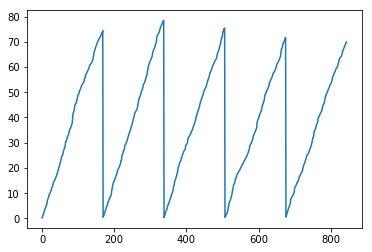

In [41]:
# FirstModel2 with a learning rate of 1e-5
m1_2 = train(firstmodel2, train_dataloader, device)

In [42]:
# torch.save(m1_2, 'firstmodel_differentconv.pt')

- Second model

In [43]:
# AlexNet
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
#         Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension)
        self.batchnorm1 = nn.BatchNorm2d(3) # output of previous layer
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm2 = nn.BatchNorm2d(3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm3 = nn.BatchNorm2d(3)
        
        self.conv4 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm4 = nn.BatchNorm2d(3)
        
        self.conv5 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm5 = nn.BatchNorm2d(3)
        
        self.pool3 = nn.MaxPool2d(2)
        
        self.linear1 = nn.Linear(3*25*25, 500)
        self.dropout1 = nn.Dropout(p=0.5) # 0.5?
        self.relu1 = nn.ReLU()
        
        self.linear2 =  nn.Linear(500, 250)
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu2 = nn.ReLU()
        
        self.linear3 = nn.Linear(250, 100)
        self.relu3 = nn.ReLU()
        
        self.sigm = nn.Sigmoid()
        
    
    def forward(self, x):
        
        y = self.conv1(x)
        y = self.batchnorm1(y)
        y = self.pool1(y)
        
        y = self.conv2(y)
        y = self.batchnorm2(y)
        y = self.pool2(y)
        
        y = self.conv3(y)
        y = self.batchnorm3(y)
        
        y = self.conv4(y)
        y = self.batchnorm4(y)
        
        y = self.conv5(y)
        y = self.batchnorm5(y)
        
        y = self.pool3(y)
        
        y = y.view(y.shape[0], -1)
        
        y = self.linear1(y)
#         y = self.dropout1(y)
        y = self.relu1(y)
        
        y = self.linear2(y)
#         y = self.dropout2(y)
        y = self.relu2(y)
        
        y = self.linear3(y)
        y = self.relu3(y)
        
        y = self.sigm(y)
        
        return y

In [44]:
# device = torch.device('cpu')
device = torch.device('cuda:1')

In [45]:
# hyperparameters 1

batch_size = 4
learning_rate = 1e-5
epochs = 5

In [15]:
secondmodel = SecondModel().to(device)
# secondmodel = torch.load("secondmodel.pt").to(device)

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.7001686286644118
0.6934773798524986
0.6932005829359653
0.6931676945742771
0.6931548270248097


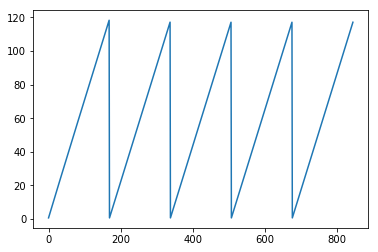

In [20]:
# Second model with a learning rate of 1e-5
m2 = train(secondmodel, train_dataloader, device)

In [39]:
# torch.save(m2, 'secondmodel.pt')

## Part 3: testing and evaluation (13 points)
You can use your test data by feeding the test images forward through the models. The output of the models will be pixel maps of the probability of a particular pixel being inside a bounding box.  These will be compared outside the model to the test data's bounding boxes.  
You can use a number of different evaluation strategies
- one of them being to choose a probability threshold to decide whether a pixel is inside the bounding box or not, and then take recall/precision/X11/accuracy. 
- Another one is to report it in terms of error, such as mean squared error. 
Even given your architectural choices, you will likely have hyperparameters to tune. 

Describe the progress of your training and testing, with graphs if necessary, in your report.

It should also be possible to **examine the effects of applying the model to individual images**.  Make it possible to **visually represent the pixel/bounding box probabilities superimposed on the original images.  Examine some of the images to conduct a qualitative error analysis of your trained models**. Include this analysis in your report.

In [40]:
val_dataloader = DataLoader(processed_val, batch_size=batch_size, shuffle=True)

In [83]:
def test(model, dataloader, device):
    upsampling = nn.Upsample((2048,2048))
    
    MSQE = nn.MSELoss()

    model.eval()

    total_loss = 0
    correct_guesses = 0
    
    loss_plot = []

    for i, (tensors, matrix) in enumerate(dataloader):
        tensors = tensors.to(device)
        matrix = matrix.to(torch.float32).to(device)

        with torch.no_grad():
            y = model(tensors)
        
#         print(y)
        reshaping = y.reshape((y.size()[0], 10, 10, 1))
        reshaping = reshaping.permute((0, 3, 1, 2))

        bigboi = upsampling(reshaping)
        output = bigboi.permute((0, 2, 3, 1))
        output = output.reshape(y.size()[0], 2048*2048)
        
        # accuracy   
        
        correct_guesses += torch.sum(torch.eq(output, matrix))
#         correct_guesses += torch.sum(torch.eq(torch.round(output), matrix))

#         print(correct_guesses)
        
        loss = MSQE(output, matrix)
        
        loss_plot.append(loss)
        
        total_loss += loss.item()
        
        # average loss for the epoch
        print(total_loss/(i+1), end='\r')

    accuracy = int(correct_guesses) / ((i+1) * batch_size * 3*2048**2)

    print('accuracy: ', accuracy)

    print('total mean squared error:', total_loss)
    
    plt.plot(loss_plot)
    
    

In [84]:
# used the validation set to tweak the models

accuracy:  0.27983643611272174
total mean squared error: 0.10159230255521834


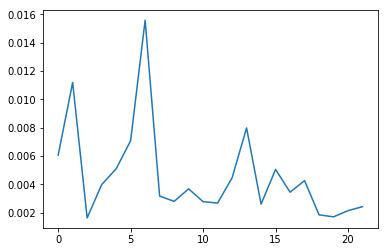

In [85]:
test(m1, val_dataloader, device)

accuracy:  0.27983643611272174
total mean squared error: 0.1029020146233961


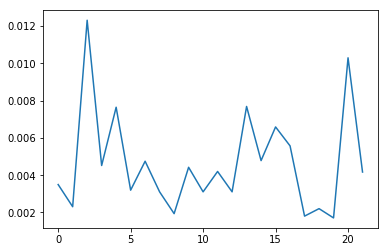

In [86]:
test(m1_1, val_dataloader, device)

accuracy:  0.2692586869904489
total mean squared error: 0.1026894758688286


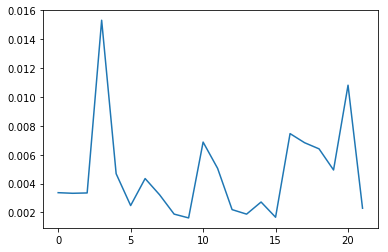

In [87]:
test(m1_2, val_dataloader, device)

accuracy:  0.034503
total mean squared error: 5.500740796327591


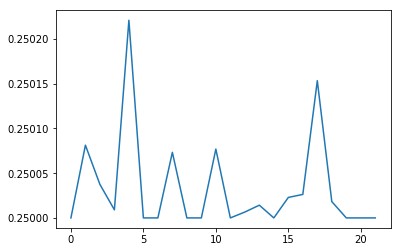

In [88]:
test(m2, val_dataloader, device)

In [54]:
# with the test dataset

In [89]:
test_dataloader = DataLoader(processed_test, batch_size=batch_size, shuffle=True)

accuracy:  0.28969583057221915
total mean squared error: 0.1115981275215745


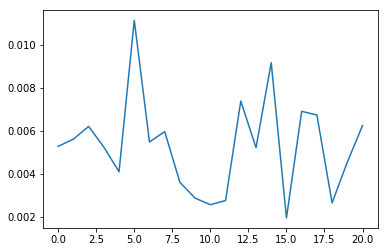

In [90]:
test(m1, test_dataloader, device)

accuracy:  0.28969583057221915
total mean squared error: 0.111598129151389


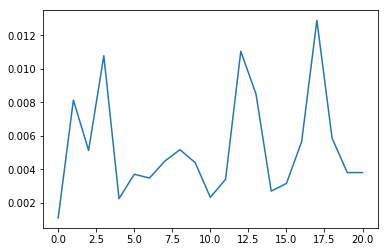

In [91]:
test(m1_1, test_dataloader, device)

accuracy:  0.2786068452729119
total mean squared error: 0.11291385896038264


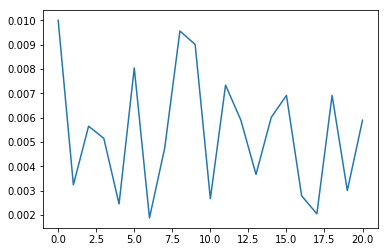

In [92]:
test(m1_2, test_dataloader, device)

accuracy:  0.029227
total mean squared error: 5.250586837530136


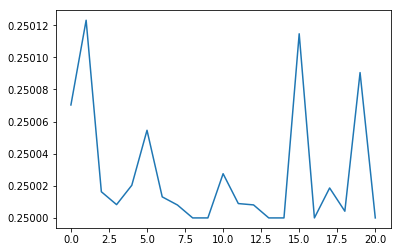

In [93]:
test(m2, test_dataloader, device)

In [61]:
# visual representations of the pixel probabilities superimposed on the original images

In [22]:
def showing_im(model, device, images = test_im_names):
    imgname = random.choice(images)
    fullimg = mpimg.imread("/scratch/lt2326-h21/a1/images/" + imgname + ".jpg")
    img = transform.resize(fullimg, (200,200))
    timg = torch.tensor(img).to(device)
    timg = timg.float()
    permute = timg.permute((2, 0, 1)).to(device)
    unsqueezeme = permute.unsqueeze(0).to(device)

    with torch.no_grad():
        y = model(unsqueezeme)

    reshaping = y.reshape((y.size()[0], 10, 10, 1))
    reshaping = reshaping.permute((0, 3, 1, 2))

    upsampling = nn.Upsample((2048,2048))
    bigboi = upsampling(reshaping)
    squeezeme = bigboi.squeeze()
    
    %matplotlib inline

    plt.imshow(fullimg)
    plt.imshow(squeezeme.cpu(), alpha=0.5)
    
    return squeezeme

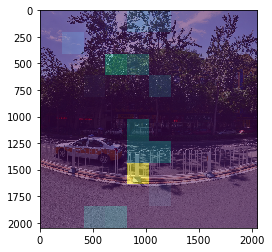

In [46]:
a = showing_im(m1, device)

In [47]:
torch.sum(a)

tensor(11442.5762, device='cuda:1')

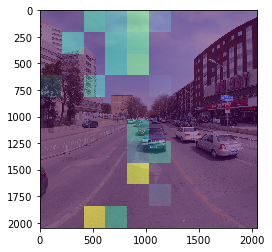

In [48]:
b = showing_im(m1, device)

In [49]:
torch.sum(b)

tensor(14227.6934, device='cuda:1')

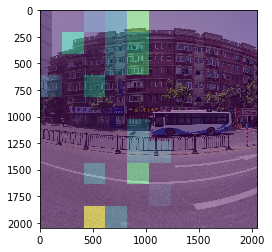

In [50]:
c = showing_im(m1_1, device)

In [51]:
torch.sum(c)

tensor(11667.2422, device='cuda:1')

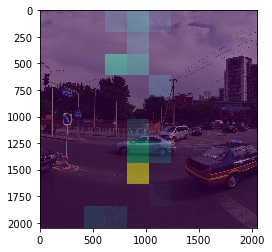

In [54]:
d = showing_im(m1_1, device)

In [55]:
torch.sum(d)

tensor(12142.7949, device='cuda:1')

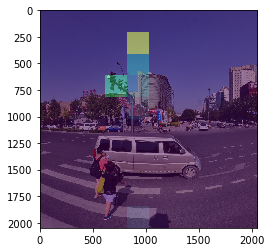

In [56]:
e = showing_im(m1_2, device)

In [57]:
torch.sum(e)

tensor(18424.2539, device='cuda:1')

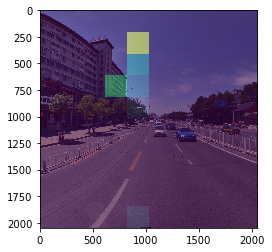

In [58]:
f = showing_im(m1_2, device)

In [59]:
torch.sum(f)

tensor(18126.8672, device='cuda:1')

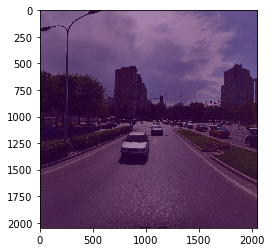

In [61]:
device='cuda:2'
g = showing_im(m2, device)

In [62]:
torch.sum(g)

tensor(2097152., device='cuda:2')

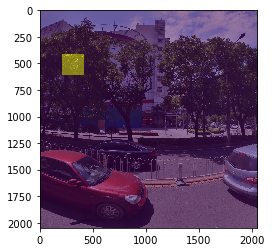

In [67]:
h = showing_im(m2, device)

In [68]:
torch.sum(h)

tensor(2097259.2500, device='cuda:2')

don't forget File > Close and Halt to be good citizens 😇